# Summarise the previous results: clean and add the volume and dual computation functions, validate the results

In [1]:

from scipy.spatial import Delaunay
#import polyscope as ps

# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Imports and physical parameters
# std library

# plotting

# ddg imports
# Allow for relative imports from main library:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#from ddgclib._case1 import *
from hyperct import *
from ddgclib._capillary_rise import * #plot_surface#, curvature
from ddgclib._misc import *
from ddgclib._plotting import *

# Name the functions we are actually using:
#from barycentric._duals import compute_vd
# Example usage:

In [2]:
# compute duals (and Delaunay dual from a set of points)
from ddgclib.ddgclib.barycentric import triang_dual

# Plots
from ddgclib.ddgclib.barycentric import plot_dual_mesh_2D, plot_dual_mesh_3D

# Geometry and dual computations
from ddgclib.ddgclib.barycentric import area_of_polygon, e_star, volume_of_geometric_object

# Boundary geometry                  
from ddgclib.ddgclib.barycentric import  _set_boundary, _find_plane_equation, _find_intersection, _reflect_vertex_over_edge

# Area computations

# DDG gradient operations on primary edges (for continuum)


# 2 D

In [3]:
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points, dtype='float64')
    tri = Delaunay(points)
    return points

In [4]:
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.

    Currently only dim = 2, 3 is supported

    cdist: float, tolerance for where a unique dual vertex can exist

    """
    # Construct dual cache
    HC.Vd = VertexCacheField()

    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()

    # hcv = copy.copy(HC.V)
    if HC.dim == 2:
        for v1 in HC.V:
            for v2 in v1.nn:
                # If boundary vertex, we stop and generate a new vertex on the boundary edge.
                try:
                    if v1.boundary and v2.boundary:
                        cd = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
                        vd = HC.Vd[tuple(cd)]
                        v1.vd.add(vd)
                        v2.vd.add(vd)
                        # Connect to dual simplex
                        v1nn_u_v2nn = v1.nn.intersection(v2.nn)  # Should always be length 1
                        v3 = list(v1nn_u_v2nn)[0]
                        verts = np.zeros([3, HC.dim])
                        verts[0] = v1.x_a
                        verts[1] = v2.x_a
                        verts[2] = v3.x_a
                        cd1 = np.mean(verts, axis=0)
                        vd1 = HC.Vd[tuple(cd1)]
                        # Connect the two dual vertices forming the boundary dual edge:
                        vd.connect(vd1)
                        continue
                except AttributeError:
                    pass
                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)  # Should always be length 2
                # In 2D there are only two
                v3_1 = list(v1nn_u_v2nn)[0]
                v3_2 = list(v1nn_u_v2nn)[1]
                if (v3_1 is v1) or (v3_2 is v1):
                    continue
                verts = np.zeros([3, HC.dim])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3_1.x_a
                # Compute the circumcentre:
                # cd = circumcenter(verts)
                # Compute the barycentre of the first connected triangle sharing primary edge/face e_1e:
                cd1 = np.mean(verts, axis=0)
                
                # Compute the barycentre of the first connected triangle sharing primary edge/face e_1e:
                verts[2] = v3_2.x_a
                cd2 = np.mean(verts, axis=0)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist1 = np.linalg.norm(vd_i.x_a - cd1)
                    dist2 = np.linalg.norm(vd_i.x_a - cd2)
                    if dist1 < cdist:
                        cd1 = vd_i.x_a
                    if dist2 < cdist:
                        cd2 = vd_i.x_a

                vd1 = HC.Vd[tuple(cd1)]
                vd2 = HC.Vd[tuple(cd2)]
                # Connect the two dual vertices:
                vd1.connect(vd2)
                
                # Connect to all primal vertices of v3_1 dual
                for v in [v1, v2, v3_1]:
                    v.vd.add(vd1)
                    
                # Connect to all primal vertices of v3_2 dual
                for v in [v1, v2, v3_2]:
                    v.vd.add(vd2)
    
    elif HC.dim == 3:
        for v1 in HC.V:
            for v2 in v1.nn:
                try:
                    # Note: every boundary primary edge only has two boundary tetrahedra connected
                    # and therefore only two barycentric dual points. We do not need to connect with
                    # other duals therefore simply connect to the primary edges.
                    if v1.boundary and v2.boundary:
                        # Find all v2.nn also connected to v1:
                        # Find the other two primary edges
                        v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                        for v3 in v1nn_u_v2nn:
                            if (v3 is v1):
                                continue
                            try:
                                if v3.boundary:
                                    # Find the barycentre of the triangle
                                    verts = np.zeros([3, HC.dim])
                                    verts[0] = v1.x_a  # TODO: Added 08.03.24, investigate accidental deletion?
                                    verts[1] = v2.x_a
                                    verts[2] = v3.x_a
                                    # Compute the circumcentre:
                                    # cd = circumcenter(verts)
                                    # Compute the barycentre:
                                    cd = np.mean(verts, axis=0) 
                                    for vd_i in HC.Vd:
                                        dist = np.linalg.norm(vd_i.x_a - cd)
                                        if dist < cdist:
                                            cd = vd_i.x_a

                                    # Define the new dual vertex on the face/triangle [v1, v2, v3]:
                                    vd123 = HC.Vd[tuple(cd)]
                                        
                                    # Find the simplex that connects to boundary face/triangle [v1, v2, v3]:
                                    v1nn_u_v2nn_u_v3nn = v1.nn.intersection(v2.nn).intersection(v3.nn)  # Always length 1
                                    print(f'len(v1nn_u_v2nn_u_v3nn) = {len(v1nn_u_v2nn_u_v3nn) }')
                                    v4 = list(v1nn_u_v2nn_u_v3nn)[0]
                                    
                                    verts = np.zeros([4, HC.dim])
                                    verts[0] = v1.x_a
                                    verts[1] = v2.x_a
                                    verts[2] = v3.x_a
                                    verts[3] = v4.x_a
                                    cd1234 = np.mean(verts, axis=0)
                                    vd1234 = HC.Vd[tuple(cd1234)]
                                    # Connect the two dual vertices forming the boundary dual edge:
                                    vd123.connect(vd1234)
                                    
                                    # Connect to all primal vertices on the boundary:
                                    for v in [v1, v2, v3, v4]:
                                        if not v.boundary:
                                            continue
                                        v.vd.add(vd123)
                                        vd123.nn.add(v)
                                        
                                    # Connect vd123 with duals of primary edges e_12 and e_13 
                                    if 1:
                                        cd12 = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
                                        vd12 = HC.Vd[tuple(cd12)]
                                        
                                        #cd13 = v1.x_a + 0.5 * (v3.x_a - v1.x_a)
                                        #vd13 = HC.Vd[tuple(cd13)]
                                        
                                        # Close out on primary border edges:
                                        #vd123.connect(vd12)
                                        #vd123.connect(vd13)
                                        
                                        # Also connect to primary edges
                                        v1.vd.add(vd12)
                                        v2.vd.add(vd12)
                                       # v1.vd.add(vd13)
                                        #v2.vd.add(vd13)
                            except AttributeError:
                                pass

                        continue
                except AttributeError:
                    pass

                # Find all v2.nn also connected to v1:
                v1nn_u_v2nn = v1.nn.intersection(v2.nn)
                for v3 in v1nn_u_v2nn:
                    if (v3 is v1):
                        continue
                    v1nn_u_v2nn_u_v3nn = v1nn_u_v2nn.intersection(v3.nn)  # Should be length 2
                    #print(f'len(v1nn_u_v2nn_u_v3nn) = {len(v1nn_u_v2nn_u_v3nn)}')
                    # In 3D there are only two
                    v4_1 = list(v1nn_u_v2nn_u_v3nn)[0]
                    v4_2 = list(v1nn_u_v2nn_u_v3nn)[1]
                    if (v4_1 is v1) or (v4_1 is v2) or (v4_2 is v1) or (v4_2 is v2):
                        continue
                        
                    # Compute the two duals of tetrahedra connected by face f_123 of triangle [v1, v2, v3]
                    verts = np.zeros([HC.dim + 1, HC.dim])
                    verts[0] = v1.x_a  #TODO: Added 08.03.24, investigate accidental deletion?
                    verts[1] = v2.x_a
                    verts[2] = v3.x_a
                    verts[3] = v4_1.x_a
                    #  Compute the barycentre of the first connected simplex sharing primary face f_123:
                    cd1 = np.mean(verts, axis=0)

                    #  Compute the barycentre of the first connected simplex sharing primary face f_123:
                    verts[3] = v4_2.x_a
                    cd2 = np.mean(verts, axis=0)
                
                    # Note instead of below, could round off cd in general to say nearest 1e-12
                    # Check for uniqueness first (new, expensive, could
                    # be improved by checking duals of neighbours only?):
                    if 0:
                        for vd_i in HC.Vd:
                            dist1 = np.linalg.norm(vd_i.x_a - cd1)
                            dist2 = np.linalg.norm(vd_i.x_a - cd2)
                            if dist1 < cdist:
                                cd1 = vd_i.x_a
                            if dist2 < cdist:
                                cd2 = vd_i.x_a
                            
                    #  Define the new dual vertices
                    vd1 = HC.Vd[tuple(cd1)]
                    vd2 = HC.Vd[tuple(cd2)]
                    # Connect the two dual vertices:
                    vd1.connect(vd2)
                    
                    # Connect to all primal vertices of v3_1 dual
                    for v in [v1, v2, v3, v4_1]:
                        v.vd.add(vd1)
                        
                    # Connect to all primal vertices of v3_2 dual
                    for v in [v1, v2, v3, v4_2]:
                        v.vd.add(vd2)
                        
                    if 0:
                        for v4 in v1nn_u_v2nn_u_v3nn:
                            if (v4 is v1) or (v4 is v2):
                                continue
                            # TODO: Re-implement cache:
                            verts = np.zeros([HC.dim + 1, HC.dim])
                            verts[0] = v1.x_a  #TODO: Added 08.03.24, investigate accidental deletion?
                            verts[1] = v2.x_a
                            verts[2] = v3.x_a
                            verts[3] = v4.x_a
    
                            # Compute the circumcentre:
                            # cd = circumcenter(verts)
                            # Compute the barycentre:
                            cd = np.mean(verts, axis=0)
                            # Note instead of below, could round off cd in general to say nearest 1e-12
                            # Check for uniqueness first (new, expensive, could
                            # be improved by checking duals of neighbours only?):
                            for vd_i in HC.Vd:
                                dist = np.linalg.norm(vd_i.x_a - cd)
                                if dist < cdist:
                                    cd = vd_i.x_a
    
                            #  Define the new dual vertex:
                            vd = HC.Vd[tuple(cd)]
                            # Connect to all primal vertices
                            for v in [v1, v2, v3]:  #TODO: WHAT ABOUT v4?!?
                                v.vd.add(vd)
                                #vd.nn.add(v)  #TODO: Investigate; I removed this 03.10.24
    return HC  # self



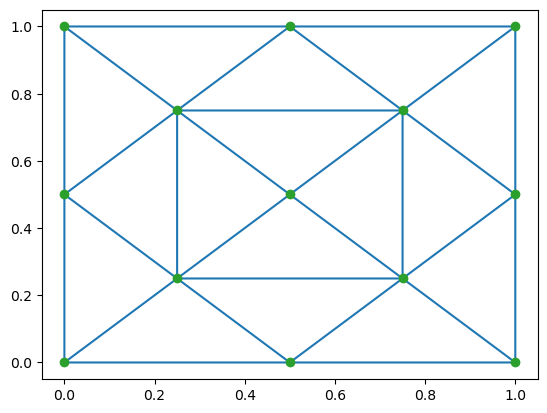

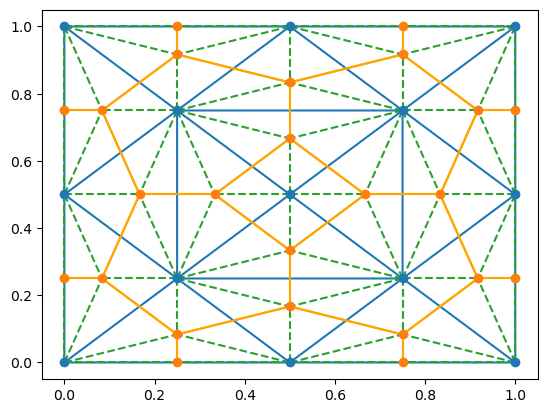

In [5]:
#NOTE: This was moved after defining the code below to validate the 2D:
domain = [(0, 1),]*2

points = incom_Poi(domain, refinements=1)
HC, tri = triang_dual(points, plot_delaunay=True)
#HC.dim = 2
# NEW: Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0) or
        (v.x_a[0] == 1.0 or v.x_a[1] == 1.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv)
    
# Now compute duals as normal   
compute_vd(HC, cdist =1e-10)

plot_dual_mesh_2D(HC, tri, points)

In [6]:
for vd in HC.Vd:
    print(vd.nn)
    print(vd)

{<ddgclib._vertex.VertexScalarField object at 0x74c0405ad450>}
{<ddgclib._vertex.VertexScalarField object at 0x74c0405b8210>, <ddgclib._vertex.VertexScalarField object at 0x74c17744ad10>, <ddgclib._vertex.VertexScalarField object at 0x74c03f88f050>}
{<ddgclib._vertex.VertexScalarField object at 0x74c0405ac150>}
{<ddgclib._vertex.VertexScalarField object at 0x74c0405ae290>, <ddgclib._vertex.VertexScalarField object at 0x74c0405ab690>, <ddgclib._vertex.VertexScalarField object at 0x74c03f88f050>}
{<ddgclib._vertex.VertexScalarField object at 0x74c0405bc0d0>, <ddgclib._vertex.VertexScalarField object at 0x74c0405ad450>, <ddgclib._vertex.VertexScalarField object at 0x74c0405ac150>}
{<ddgclib._vertex.VertexScalarField object at 0x74c0405a8250>, <ddgclib._vertex.VertexScalarField object at 0x74c0405bc0d0>, <ddgclib._vertex.VertexScalarField object at 0x74c03f843210>}
{<ddgclib._vertex.VertexScalarField object at 0x74c03f88f050>, <ddgclib._vertex.VertexScalarField object at 0x74c0405ab410>, <

# 3 D


#### Test if the sum of unit cube dual volumes is 1 m$^3$ as expected

len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3nn) = 1
len(v1nn_u_v2nn_u_v3

/home/endres/projects/ddg/ddgclib/ddgclib/_complex.py:2906: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_complex.show()


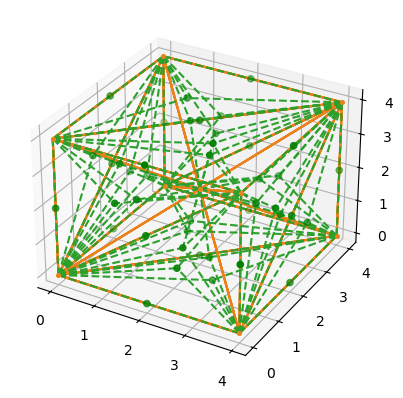

In [7]:
domain = [(0, 4.0),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
for i in range(0):
    HC.refine_all_star()

# NEW
# Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0 or v.x_a[2] == 0.0) or
        (v.x_a[0] == 4.0 or v.x_a[1] == 4.0 or v.x_a[2] == 4.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv, True)
for v in HC.V:
    if not (v in bV):
        _set_boundary(v, False)
    
    
#for v in HC.V:
#    if (v in bV):
#        continue
#    else:
#        _set_boundary(bv, False)
        
# Compute duals     
compute_vd(HC, cdist =1e-10)

# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
#dual_points

import polyscope as ps
v = HC.V[(0.0, 0.0, 0.0)]
v2 = HC.V[(0.0, 4.0, 4.0)]
#TEST fix of dual point:
#vd = [0.0, 1.5, 2.5]


In [8]:
#NOTE: Change be unchanged from _duals.py
class _PlanePoints:
    """
    A special helper class for plot_dual to define attributes when tri is known, but can't be found with QHull due to
    too few points
    """
    def __init__(self, simplices, points):
        self.simplices = simplices
        self.points = points

def plot_dual(v, HC, vector_field=None, scalar_field=None, fn='', up="x_up"
              , stl=False):
    v1 = v
    # Initialize polyscope
    ps.init()
    ps.set_up_dir('z_up')

    do = coldict['do']
    lo = coldict['lo']
    db = coldict['db']
    lb = coldict['lb']
    tg = coldict['tg']  # Tab:green colour
    ## Plot dual mesh
    # Loop over primary edges
    dual_points_set = set()
    ssets = []  #  Sets of simplices 
    for i, v2 in enumerate(v1.nn):
        # For each primary edge:
        # Check if boundary edged:
        #print(f'v2.x = {v2.x}')
        if (v1.boundary) and (v2.boundary):
            # Each boundary edge should have 4 vertices and 3 flux triangles
            #print("Boundary e12")
            dset = v2.vd.intersection(v1.vd)  #.intersection(v.vd), always length 5
            print('=')
            print(f'dset len = {len(list(dset))}')
            pset = v2.nn.intersection(v1.nn)  # Unfortunately includes non-boundary vertices
            for v3 in pset:
                if v3.boundary:  # Two boundaries connected to each primary edge e_12
                    print('-')
                    dset123 = v1.vd.intersection(v2.vd)
                    dset123 = dset123.intersection(v3.vd)
                    # dset123 is the two boundary dual vertices (one dual to e_12 and one dual to tri_123)
                    print(f'len(dset123) = {len(dset123)}')
                    for vd_i in dset123:
                        #print(f'len(vd_i.nn) = {len(vd_i.nn)}')
                        if len(vd_i.nn) == 2:
                            vd_12 = vd_i  # The dual of edge e_12
                            #print(f'vd_12 = {vd_12.x}')
                        else:
                            vd_123 = vd_i
                            
                    # The last vertex (dual one of the boundary tetrahedrons) 
                    # needed is connect to vd_123 and v1
                    vd_1234 = dset.intersection(vd_123.nn.intersection(v1.vd))
                    #print(f'vd_1234  = {vd_1234 }')
                # None boundary vertices:
                else:
                    pass
            #print(f'pset len = {len(list(pset))}')
           # print(f'dset len = {len(list(dset))}')
            for vd1 in dset:
                pass  #print(f'vd1.nn = {vd1.nn}')
            for v3 in v2.nn:
                pass  #dset = v2.vd.intersection(v.vd)#.intersection(v.vd)
                
        else:
            print('===')
            print(f'v1 = {v1.x}')
            print(f'v2 = {v2.x}')
            print("Not boundary e12")
            # Find the dual vertex of e12:
            vc_12 = 0.5*(v2.x_a - v1.x_a) + v1.x_a
            vc_12 = HC.Vd[tuple(vc_12)]
            # Find local dual points intersecting vertices terminating edge:
            dset = v2.vd.intersection(v1.vd)
            print(f'dset = {dset}')
           # dset = collections.OrderedDict(list(dset))
            print(f'len(dset) = {len(dset)}')

            # Start with the first vertex and then build triangles, loop back to it:
            vd_i = list(dset)[0]
            print(f'list(dset)[0].x = {list(dset)[0].x}')
            dsetnn = vd_i.nn.intersection(dset)  # Always 2 internal dual vertices
            vd_j = list(dsetnn)[0]
            #ssets.append([vc_12, vd_i, vd_j])
            #ssets.append([vc_12, vd_i, list(dsetnn)[1]])  # the close out simplex
            vd_i_1 = vd_i
            for vd in list(dset)[1:]:
                #dsetnn_k = vd_j.nn.intersection(dset)  # Always 2 internal dual vertices
                dsetnn_k = vd_j.nn.intersection(dset)  # Always 2 internal dual vertices
                print(f'dsetnn_k = {dsetnn_k}')
                print(f'vd_i = {vd_i}')
                #dsetnn_k.remove(vd_i)  # Should now be size 1
                dsetnn_k.remove(vd_i_1)  # Should now be size 1
                vd_i_1 = vd_j
                vd_j = list(dsetnn_k)[0]  # Retrieve the next vertex
                print(f'vd_j = {vd_j}')
                ssets.append([vc_12, vd_i, vd_j])
                # Set new j to i index
                vd_i = vd_j
                #vd1 = list
                
                print(f'len(dsetnn) = {len(dsetnn)}')
            #ssets.append([vc_12, vd_i, vd_j])
            print('===')
            
        # find local dual points intersecting vertices terminating edge:
        if 1:
            dset = v2.vd.intersection(v1.vd)
            pi = []
            for vd in dset:
                # pi.append(vd.x + 1e-9 * np.random.rand())
                pi.append(vd.x)
                dual_points_set.add(vd.x)
            pi = np.array(pi)
            pi_2d = pi[:, :2] + 1e-9 * np.random.rand()
            
            # Plot dual points:
            dual_points = []
            for vd in dual_points_set:
                dual_points.append(vd)
        
            dual_points = np.array(dual_points)
            ps_cloud = ps.register_point_cloud("Dual points", dual_points)
            ps_cloud.set_color(do)
        
        if 0:
            # Find the (delaunay) simplices from scipy:
            try:
                tri = scipy.spatial.Delaunay(pi_2d, qhull_options='QJ')
            except QhullError as e:
                #NOTE: This should not be needed in the future, but during development some
                #      boundary primary edges only have 3 vertices associated with them. There-
                #      a quick hack is to do the manual triangulation below:
                print(f'e = {e}')
                simplices = [[0, 1, 2]]
                points = pi
                tri = _PlanePoints(simplices, points)
                pass  # print(e)
            
            verts = pi
            faces = tri.simplices
            dsurface = ps.register_surface_mesh(f"Dual face {i}", verts, faces,
                                                color=do,
                                                edge_width=0.0,
                                                edge_color=(0.0, 0.0, 0.0),
                                                smooth_shade=False)
    
            dsurface.set_transparency(0.7)

    # New plot of Barycentric simplces
    if 1:
        # Now build the simplices for plotting
        #verts = np.array(verts)
        # Now iterate through all the constructed simplices and find indexes 
        faces = []
        vdict = collections.OrderedDict()  # Ordered cache of vertices to plot 
        ind = 0
        for s in ssets:
            f = []
            for v in s:
                if not (v.x in vdict):
                    vdict[v.x] = ind
                    ind += 1
                
                f.append(vdict[v.x])
            faces.append(f)
        
        print(f'vdict = {vdict}')
        print(f'list(vdict.keys()) = {list(vdict.keys())}')
        verts = np.array(list(vdict.keys()))
        faces = np.array(faces)
        #verts = []
        # Iterate the ordered set
        #vdict = {}
        #hash(v.x) in vdict 
        #vdict[hash(v.x)] = 1
        
       # for v in HC.V:
        #    print(f'v.index = {v.index}')
       #     verts.append(v.x_a)
        
    
        #for s in ssets:
        #    f = []
        #    for v in s:
        #        f.append(v.index)
        #    faces.append(f)
            
        faces = np.array(faces)    
        print(f'verts = {verts}')
        print(f'verts.shape = {verts.shape}')
        print(f'faces = {faces}')
        #tri = _PlanePoints(faces, verts)        
        #faces = tri.simplices
        
        dsurface = ps.register_surface_mesh(f"Dual face {i}", verts, faces,
                                            color=do,
                                            edge_width=0.0,
                                            edge_color=(0.0, 0.0, 0.0),
                                            smooth_shade=False)


    # Plot primary mesh
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    
    ### Register the primary vertices as a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("Primary points", my_points)
    ps_cloud.set_color(tuple(db))
    # ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    if stl:
        print(f'verts = {verts}')
        print(f'faces = {faces}')
        #  msh = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
        for i, f in enumerate(faces):
            for j in range(3):
                pass
                # msh.vectors[i][j] = verts[f[j], :]

        # msh.save(f'{fn}.stl')
        
    ### Plot the primary mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    if 1:
        surface = ps.register_surface_mesh("Primary surface", verts, faces,
                                           color=db,
                                           edge_width=1.0,
                                           edge_color=(0.0, 0.0, 0.0),
                                           smooth_shade=False)
    
        surface.set_transparency(0.3)
        # Add a scalar function and a vector function defined on the mesh
        # vertex_scalar is a length V numpy array of values
        # face_vectors is an Fx3 array of vectors per face
    
        # View the point cloud and mesh we just registered in the 3D UI
        # ps.show()
        # Plot particles
        # Ground plane options
        ps.set_ground_plane_mode("shadow_only")  # set +Z as up direction
        ps.set_ground_plane_height_factor(0.1)  # adjust the plane height
        ps.set_shadow_darkness(0.2)  # lighter shadows
        ps.set_shadow_blur_iters(2)  # lighter shadows
        ps.set_transparency_mode('pretty')
        # ps.look_at((0., -10., 0.), (0., 0., 0.))
        ps.look_at((1., -8., -8.), (0., 0., 0.))
        # ps.set_ground_plane_height_factor(x, is_relative=True)
        ps.set_screenshot_extension(".png")
        # Take a screenshot
        # It will be written to your current directory as screenshot_000000.jpg, etc
        ps.screenshot(fn)
    return ps


v = HC.V[(2.0, 2.0, 2.0)]
v = HC.V[(0.0, 0.0, 0.0)]
plot_dual(v, HC)
ps.show()


[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 565.77
=
dset len = 5
-
len(dset123) = 2
-
len(dset123) = 2
=
dset len = 5
-
len(dset123) = 2
-
len(dset123) = 2
===
v1 = (0, 0, 0)
v2 = (2.0, 2.0, 2.0)
Not boundary e12
dset = {<ddgclib._vertex.VertexScalarField object at 0x74c03f7283d0>, <ddgclib._vertex.VertexScalarField object at 0x74c03f728fd0>, <ddgclib._vertex.VertexScalarField object at 0x74c03f729250>, <ddgclib._vertex.VertexScalarField object at 0x74c03f728b90>, <ddgclib._vertex.VertexScalarField object at 0x74c03f729150>, <ddgclib._vertex.VertexScalarField object at 0x74c03f728c50>}
len(dset) = 6
list(dset)[0].x = (0.5, 1.5, 2.5)
dsetnn_k = {<ddgclib._vertex.VertexScalarField object at 0x74c03f7283d0>, <ddgclib._vertex.VertexScalarField object at 0x74c03f728c50>}
vd_i = <ddgclib._vertex.VertexScalarField object at 0x74c03f7283d0>
vd_j = <ddgclib._vertex.VertexScalarField object at 0x74c03f728c50>
len(dsetnn) = 2
dsetnn_k = {<ddgclib._vertex.VertexScalar

In [9]:
hash(v.x)

3010437511937009226

In [10]:
vdict = collections.OrderedDict()
hash(v.x) in vdict 
vdict[hash(v.x)] = 1
hash(v.x) in vdict 

True

In [11]:
vdict = {}
hash(v.x) in vdict 
vdict[hash(v.x)] = 1
hash(v.x) in vdict 

True

In [12]:
A

NameError: name 'A' is not defined

In [ ]:
domain = [(0, 4.0),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
for i in range(0):
    HC.refine_all_star()

# NEW
# Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0 or v.x_a[2] == 0.0) or
        (v.x_a[0] == 4.0 or v.x_a[1] == 4.0 or v.x_a[2] == 4.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv, True)
for v in HC.V:
    if not (v in bV):
        _set_boundary(v, False)
    
    
#for v in HC.V:
#    if (v in bV):
#        continue
#    else:
#        _set_boundary(bv, False)
        
# Compute duals     
compute_vd(HC, cdist =1e-10)

# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
#dual_points

import polyscope as ps
v = HC.V[(0.0, 0.0, 0.0)]
v2 = HC.V[(0.0, 4.0, 4.0)]
#TEST fix of dual point:
#vd = [0.0, 1.5, 2.5]
if 0:
   # vd = [0.0, 1.6, 2.4]
    #vd = [0.09478826,  0.5,      2.37244094]
    vd1 = [-1.,  1.,  2.]
    vd2 = [0., 1., 3.]
    vd1 = [-0. ,  1.6,  2.4]
    vd2 = [-0. ,  1.6,  2.4]
    for vd in [vd1, vd2]:
        vd = HC.Vd[tuple(vd)]
        v.vd.add(vd)
        v2.vd.add(vd)

plot_dual(v, HC)
ps.show()

In [ ]:
for v in HC.V:
    print(v.boundary)

In [ ]:
0.3*np.random.rand(9, 3)
mv = np.array([[0.25910174, 0.05709758, 0.18128292],
       [0.17033245, 0.13904646, 0.28146628],
       [0.23101158, 0.08850447, 0.2979514 ],
       [0.02608313, 0.23364049, 0.16710522],
       [0.24475869, 0.2535351 , 0.23581602],
       [0.24480598, 0.29116136, 0.0278181 ],
       [0.15951228, 0.05554161, 0.17810271],
       [0.10337674, 0.08659427, 0.19180384],
       [0.06494703, 0.18033121, 0.00913594]])
mv
domain = [(0, 4.0),]*3
#symmetry = [0, 1, 1]
HC = Complex(3, domain=domain, symmetry=None)
HC.triangulate()
for i in range(0):
    HC.refine_all_star()

# NEW
# Compute boundaries
bV = set()
for v in HC.V:
    if ((v.x_a[0] == 0.0 or v.x_a[1] == 0.0 or v.x_a[2] == 0.0) or
        (v.x_a[0] == 4.0 or v.x_a[1] == 4.0 or v.x_a[2] == 4.0)):
        bV.add(v)
        
for bv in bV:
    _set_boundary(bv, True)
    
for v, mvi in zip(HC.V, mv):
    print(mvi)
    vt = tuple(v.x_a + 5*mvi)
    HC.V.move(v, vt)
    
#for v in HC.V:
#    if (v in bV):
#        continue
#    else:
#        _set_boundary(bv, False)
        
# Compute duals     
HC.V.merge_all(cdist=1e-6)
compute_vd(HC, cdist =1e-10)

# Add dual points
dual_points = []
for vd in HC.Vd:
    dual_points.append(vd.x_a)
    

dual_points = np.array(dual_points, dtype='float64')
#hcaxes.scatter(dual_points)
plot_dual_mesh_3D(HC, dual_points)
#dual_points


In [ ]:
for v in HC.V:
    break

In [ ]:
plot_dual(v, HC)
ps.show()

In [ ]:
import numpy as np

def cross_product(a, b):
    return np.cross(a, b)

def dot_product(a, b):
    return np.dot(a, b)

class Tetrahedron:
    def __init__(self, v0, v1, v2, v3):
        self.vertices = np.array([v0, v1, v2, v3])

    # Returns point P in barycentric coordinate system
    def get_point(self, alpha, beta, gamma, delta):
        p = alpha * self.vertices[0] + \
            beta * self.vertices[1] + \
            gamma * self.vertices[2] + \
            delta * self.vertices[3]
        
        return p

    # Computes intersection point between an edge and its corresponding plane
    def get_intersection_point(self, pa, pb, plane_normal, plane_constant):
        ab = pb - pa
        denominator = dot_product(ab, plane_normal) + 1e-9  # Adding a small number here
        t = (plane_constant - dot_product(pa, plane_normal)) / denominator
        intersection_point = pa + t * ab
        return intersection_point

    # Computes all required intersection points
    def get_edge_intersections(self, q, r, s):
        edge_intersections = []

        # Face ABC
        e = cross_product(self.vertices[1] - self.vertices[0], self.vertices[2] - self.vertices[0])
        f = dot_product(e, self.vertices[0])

        edge_intersections += [self.get_intersection_point(self.vertices[0], self.vertices[1], e, f)]
        edge_intersections += [self.get_intersection_point(self.vertices[0], self.vertices[2], e, f)]
        edge_intersections += [self.get_intersection_point(self.vertices[0], self.vertices[3], f*np.array((1, 0, 0)), dot_product(self.vertices[3], f*np.array((1, 0, 0))))]
        edge_intersections += [self.get_intersection_point(self.vertices[1], self.vertices[3], f*np.array((0, 1, 0)), dot_product(self.vertices[3], f*np.array((0, 1, 0))))]
        edge_intersections += [self.get_intersection_point(self.vertices[2], self.vertices[3], f*np.array((0, 0, 1)), dot_product(self.vertices[3], f*np.array((0, 0, 1))))]

        return edge_intersections

# Usage example
v0 = np.array([0, 0, 0])
v1 = np.array([1, 0, 0])
v2 = np.array([0, 1, 0])
v3 = np.array([0, 0, 1])

tetrahedron = Tetrahedron(v0, v1, v2, v3)
alpha, beta, gamma, delta = 0.2, 0.3, 0.3, 0.2
q = tetrahedron.get_point(alpha, beta, gamma, 0)
r = tetrahedron.get_point(alpha, 0, delta, beta)
s = tetrahedron.get_point(0, gamma, delta, alpha)

edge_intersections = tetrahedron.get_edge_intersections(q, r, s)
print("Edge Intersections:", edge_intersections)

In [ ]:
import numpy as np
def compute_dual_on_boundary_face(v1, v2, bV):
    """
    Computes the dual vertex that is on the boundary face, there are two of these
    duals associated with every primal edge e_12 = v2 - v1. generates vd1 and vd2 
    connected to three primal vertices each.
    :param v1: origin vertex, must have the v1.boundary = True property
    :param v2: termination vertex, must have the v1.boundary = True property
    :return: None
    """

    #TODO: Remove older code in main loop that does this:
    # Compute the dual on the primary edge
    cd = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
    vd12 = HC.Vd[tuple(cd)]
    v1.vd.add(vd12)
    v2.vd.add(vd12)
    
    # Find the other two duals connected to both v1 and v2,
    # the set v1vd_n_v2vd should be length 3:
    v1vd_n_v2vd = v1.vd.intersection(v2.vd)
    v1vd_n_v2vd = v1vd_n_v2vd.difference(HC.V_bfaces)

    # Find all v2.nn also connected to v1:
    # Find the other two primary edges
    v1nn_n_v2nn = v1.nn.intersection(v2.nn)
    # Check if we already have verts defined for both boundary faces, 
    # we can then exit this routine:
    if len(HC.V_bfaces.intersection(v1nn_n_v2nn)) > 2:
        return
    
    for v3 in v1nn_n_v2nn:
        print('-')
        print(f'v3.x = {v3.x}')
        print(f'(v3 not in bV) = {(v3 not in bV)}')
        if (v3 is v1) or (v3 not in bV):
            continue  # Unneeded?
        try:
            if v3.boundary:
                # Found one of two boundary triangles, vd_i lies in this plane
                tri1 = np.array([v1.x_a, 
                                 v2.x_a, 
                                 v3.x_a])
                # Find the 3 vertices forming the triangle dual to e_13 = v3 - v1
                cd = v1.x_a + 0.5 * (v3.x_a - v1.x_a)
                vd13 = HC.Vd[tuple(cd)]
                v1.vd.add(vd13)
                v3.vd.add(vd13)

                # Find the duals of the v1, v3 tetrahedron
                #TODO: Remove HC.V_bfaces here(?):
                v1vd_n_v3vd = v1.vd.intersection(v3.vd)
                v1vd_n_v3vd = v1.vd.intersection(v3.vd).difference(HC.V_bfaces)
                # The vertex to be flipped is not vd13 and not connected to v2
                vd13_l = []
                for i, vd in enumerate(v1vd_n_v3vd):
                    vd13_l.append(vd.x_a)
                    if ((vd not in v2.vd)) and (vd is not vd13):
                        flip_ind = i

                tri3 = np.array(vd13_l)
                print(f'tri3  = {tri3}')
                tri3 = _reflect_vertex_over_edge(tri3, target_index=flip_ind)

                
                # Finally find the third triangle
                # Find the 3 vertices forming the triangle dual to e_12
                # Find the reflected triangle of the edge e_12 = v2 - v1
                vd12_l = []
                for i, vd in enumerate(v1vd_n_v2vd):
                    vd12_l.append(vd.x_a)
                    if (not vd in v3.vd) and (not vd is vd12):
                        flip_ind = i
                        
                tri2 = np.array(vd12_l)
                print(f'tri2  = {tri2}')
                tri2 = _reflect_vertex_over_edge(tri2, target_index=flip_ind)
                # Find the 3 vertices forming the triangle dual to e_12

        except AttributeError:
            continue

        # Finally find the dual solution 
        planes = []
        tri1 = np.array(tri1,dtype=np.float64)
        tri2 = np.array(tri2,dtype=np.float64)
        tri3 = np.array(tri3,dtype=np.float64)
        print(f'tri1, tri2, tri3 = {tri1, tri2, tri3}')
        for tri in [tri1, tri2, tri3]:
             plane = _find_plane_equation(tri[0], tri[1], tri[2])
             planes.append(plane)
        try:
            vd_123 = _find_intersection(planes[0], planes[1], planes[2])
        except ValueError as ve:
            print(f'{ve}')
            continue
        vd_123 = HC.Vd[tuple(vd_123)]
        print(f'vd_123.x = {vd_123.x}')
        #TODO: CHECK WHAT IS NEEDED:
        v1.vd.add(vd_123)
        v2.vd.add(vd_123)
        # Add the newly founded vertices to  HC.V_bfaces so that it 
        # doesn't get reused
        HC.V_bfaces.add(vd_123)
        
        
        
#NOTE: It is _needed_ to first define this set to preserve triangles 
#      and lower algorithmic complexity.
HC.V_bfaces = getattr(HC, 'V_bfaces', set())

if 0:
    v1 = HC.V[0,0,0]
    v2 = HC.V[0,0,4]
    compute_dual_on_boundary_face(v1, v2)
    
    v1 = HC.V[0,0,0]
    v2 = HC.V[0,4,4]
    compute_dual_on_boundary_face(v1, v2)
    
    
    #v1 = HC.V[0,4,4]
    #v2 = HC.V[0,0,0]
    compute_dual_on_boundary_face(v1, v2)
    
v1 = HC.V[0,0,0]
#v1 = HC.V[0,4,0]
v = v1 
for v2 in v1.nn:
    if not (v2 in bV):
        continue
    print(f'v2.x = {v2.x}')
    compute_dual_on_boundary_face(v1, v2, bV)
#plot_dual(v, HC)
#ps.show()

In [ ]:
plot_dual(v, HC)
ps.show()

In [ ]:
# Confirm that the bottom dual plane is just a visual defect, this should have 5 dual vertices
# forming the dual plane polygon:

v1 = HC.V[0,0,0]
v2 = HC.V[4,4,0]
dset = v1.vd.intersection(v2.vd)
dset, len(dset)

In [ ]:
# Next try only adding the next primary vertex and figure out why we get multiple duals:
v1 = HC.V[0,4,0]
v = v1 
for v2 in v1.nn:
    if not (v2 in bV):
        continue
    print('-')
    print('-')
    print(f'v2.x = {v2.x}')
    compute_dual_on_boundary_face(v1, v2, bV)

In [ ]:
v = HC.V[0, 4, 0]
plot_dual(v, HC)
ps.show()

In [ ]:
#v = HC.V[0,0,0]
#plot_dual(v, HC)
#ps.show()


In [ ]:
HC.V_bfaces = getattr(HC, 'V_bfaces', set())
# Compute for all boundaries
for v1 in bV:
    for v2 in v1.nn:
        if not (v2 in bV):
            continue

        compute_dual_on_boundary_face(v1, v2, bV)
        
plot_dual(v, HC)
ps.show()

In [ ]:



# Example planes represented as ax + by + cz + d = 0
plane1 = [2, -1, 1, -1]
plane2 = [1, 1, -1, 2]
plane3 = [3, -2, -1, 3]

intersection_point = find_intersection(plane1, plane2, plane3)

print("Intersection Point:", intersection_point)



# Example vertices of a triangle
vertex1 = [1, 2, 3]
vertex2 = [4, 5, 6]
vertex3 = [7, 8, 9]

# Find the plane equation coefficients
plane_equation = find_plane_equation(vertex1, vertex2, vertex3)

print("Plane Equation Coefficients:", plane_equation)


# Find for our problem:
triangle = np.array([[0.0, 0.0, 0.0],
                     [0.0, 0.0, 4.0],
                     [0.0, 4.0, 4.0]])

triangle2 = np.array([[ 0.5, 2.5, 1.5],
                      [0, 2, 2],
                      [ 0.5, 1.5, 2.5]])

triangle3 = np.array([[0, 0, 2 ],
                      [1.5, 0.5, 2.5],
                      [0.5, 1.5, 2.5  ]])

planes = []
for t in [triangle, triangle2, triangle3]:
    plane_equation = find_plane_equation(t[0], t[1], t[2])
    planes.append(plane_equation)
    
plane1, plane2, plane3 = planes
print( planes)
find_intersection(plane1, plane2, plane3)


In [ ]:
# Generated test code below (Not worth reading!)

In [ ]:
import numpy as np




triangle = np.array([[1.5, 0.5, 2.5],
                     [0, 0, 2],
                     [0.5, 1.5, 2.5 ]])

print("Original Triangle:", triangle[0])

index_to_reflect = 0
reflected_triangle = reflect_vertex_over_edge(triangle, target_index=0)

print("Reflected Triangle 1:", reflected_triangle[0])

triangle2 = np.array([[ 0.5, 2.5, 1.5],
                      [0, 2, 2],
                      [ 0.5, 1.5, 2.5]])

index_to_reflect = 0
reflected_triangle = reflect_vertex_over_edge(triangle2, target_index=0)

print("Reflected Triangle 2:", reflected_triangle[0])

triangle3 = np.array([[0, 0, 2 ],
                      [1.5, 0.5, 2.5],
                      [0.5, 1.5, 2.5  ]])

xp1, yp1, zp1 = 0.0, 0.0, 0.0 # v1
xp2, yp2, zp2 = 0.0, 0.0, 4.0  # v2
xp3, yp3, zp3 = 0.0, 4.0, 4.0  # v3
# Dual triangle 1, dual to e12
x1, y1, z1 = 0, 0, 2  # vp1 dual to v1 and e12
x2, y2, z2 = 1.5, 0.5, 2.5  # vp2 dual to e12
x3, y3, z3 = 0.5, 1.5, 2.5  # vp3 dual to e12
# Dual triangle 2, dual to e13
x4, y4, z4 = 0, 2, 2
x5, y5, z5 = 0.5, 1.5, 2.5
x6, y6, z6 = 0.5, 2.5, 1.5




# Generated test code below (Not worth reading!)

In [ ]:
import numpy as np

def calculate_normal_vector(point1, point2, point3):
    vector1 = np.array(point2) - np.array(point1)
    vector2 = np.array(point3) - np.array(point1)
    normal_vector = np.cross(vector1, vector2)
    return normal_vector / np.linalg.norm(normal_vector)

def reflect_vertex(original_triangle, vertex_index):
    point1, point2, point3 = original_triangle
    normal_vector = calculate_normal_vector(point1, point2, point3)

    # Calculate the reflection of the vertex over the opposing edge
    reflected_vertex = original_triangle[(vertex_index + 1) % 3] + 2 * (np.dot(original_triangle[vertex_index] - original_triangle[(vertex_index + 1) % 3], normal_vector) / np.dot(normal_vector, normal_vector)) * normal_vector

    # Ensure that the reflected vertex remains in the same plane
    reflected_vertex -= np.dot(reflected_vertex - point1, normal_vector) * normal_vector / np.dot(normal_vector, normal_vector)

    return reflected_vertex

# Example usage:
original_triangle = [
    np.array([0, 0, 0]),
    np.array([1, 0, 0]),
    np.array([0, 1, 0])
]

vertex_index_to_flip = 2
reflected_vertex = reflect_vertex(original_triangle, vertex_index_to_flip)

print("Original Triangle:", original_triangle)
print("Reflected Vertex:", reflected_vertex)


In [ ]:

def calc_normal(v1, v2, v3):
    e1 = v2 - v1
    e2 = v3 - v1
    return np.cross(e1, e2)
def calc_point_in_triangle_plane(n, vp1, vp2, vp3):
    # Plane passing through vp1, vp2, and vp3
    p = np.dot(np.cross(vp2 - vp1, vp3 - vp1), n) / np.dot(n, n)
    return vp1 - p * n
def solver():
    v1, v2, v3 = np.array([x1, y1, z1]), np.array([x2, y2, z2]), np.array([x3, y3, z3])
    v4, v5, v6 = np.array([x4, y4, z4]), np.array([x5, y5, z5]), np.array([x6, y6, z6])
    
    # Step 1: Compute triangle normals
    nt1 = calc_normal(v1, v2, v3)
    nt2 = calc_normal(v4, v5, v6)
    
    # Check if normals are almost parallel
    if abs(np.dot(nt1, nt2)) < 1e-8:
        print("Triangle normals seem to be nonparallel.")
        return None
    
    # Step 3: Define the common plane
    vp1, vp2, vp3 = np.array([xp1, yp1, zp1]), np.array([xp2, yp2, zp2]), np.array([xp3, yp3, zp3])
    avg_norm = (nt1 + nt2) / 2
    vp_prime = (v1 + v2 + v3 + v4 + v5 + v6) / 6  # Any combination works here
    plane_equation = np.dot(avg_norm, (_ - vp_prime))
    
    # Step 4: Determine if point v_7 lies within triangle t3
    edge1 = vp2 - vp1
    edge2 = vp3 - vp1
    prod_edge1_edge2 = np.cross(edge1, edge2)
    lambda_cond = ((prod_edge1_edge2 == 0.) | (np.sign(np.dot(prod_edge1_edge2, _ - vp1)) != np.sign(np.dot(prod_edge1_edge2, vp3 - vp1))))
    constraint = ~lambda_cond
    
    # Step 5: Solve for point v_7
    A = np.eye(3)
    A[:,-1] = -avg_norm
    b = np.zeros(3)
    b[-1] = np.dot(avg_norm, vp_prime)
    res = np.linalg.solve(A, b)
    v7 = np.append(res, 0)  # Add a dummy coordinate for compatibility purposes later
    
    # Ensure that v_7 falls inside triangle t3
    mask = np.all((v7 >= vp1) & (v7 <= vp3), axis=-1)
    valid_points = v7[(mask[:,None]).repeat(3, axis=1)]
    num_valid_points = sum(mask)
    
    if num_valid_points == 0:
        print("No suitable point was found.")
        return None
    elif num_valid_points == 1:
        print(f"Found unique point {valid_points} lying in planes of both triangles and within triangle t3")
    else:
        print(f"Found {num_valid_points} possible points lying in planes of both triangles and within triangle t3")
        print("These points are:", valid_points)
        
    # Optionally remove the homogeneous coordinate from v7
    if num_valid_points == 1:
        v7 = valid_points[0][:-1]
    return v7
# Replace the values below with your actual input data
# Primary vertices
xp1, yp1, zp1 = 0.0, 0.0, 0.0 # v1
xp2, yp2, zp2 = 0.0, 0.0, 4.0  # v2
xp3, yp3, zp3 = 0.0, 4.0, 4.0  # v3
# Dual triangle 1, dual to e12
x1, y1, z1 = 0, 0, 2  # vp1 dual to v1 and e12
x2, y2, z2 = 1.5, 0.5, 2.5  # vp2 dual to e12
x3, y3, z3 = 0.5, 1.5, 2.5  # vp3 dual to e12
# Dual triangle 2, dual to e13
x4, y4, z4 = 0, 2, 2
x5, y5, z5 = 0.5, 1.5, 2.5
x6, y6, z6 = 0.5, 2.5, 1.5

result = solver()
if result is not None:
    print(f"The resulting point after applying the constraints is {result}")
else:
    print("Unable to determine a suitable point v_7.")

In [ ]:
import numpy as np
def calc_normal(vertices):
    e1 = vertices[1, :] - vertices[0, :]
    e2 = vertices[2, :] - vertices[0, :]
    return np.cross(e1, e2)
def constrained_point_on_planes(t1_verts, t2_verts, t3_verts):
    # Step 1: Compute triangle normals
    nt1 = calc_normal(t1_verts)
    nt2 = calc_normal(t2_verts)

    # Check if normals are almost parallel
    if abs(np.dot(nt1, nt2)) < 1e-8:
        raise ValueError("Triangle normals seem to be nonparallel.")

    # Step 3: Define the common plane
    vp = (t1_verts.sum(axis=0) + t2_verts.sum(axis=0)) / 2
    avg_norm = (nt1 + nt2) / 2
    plane_equation = np.dot(avg_norm, (_ - vp))

    # Step 4: Determine if point v_7 lies within triangle t3
    edge1 = t3_verts[1, :] - t3_verts[0, :]
    edge2 = t3_verts[2, :] - t3_verts[0, :]
    prod_edge1_edge2 = np.cross(edge1, edge2)
    lambda_cond = ((prod_edge1_edge2 == 0.) | (np.sign(np.dot(prod_edge1_edge2, _ - t3_verts[0, :])) != np.sign(np.dot(prod_edge1_edge2, t3_verts[2, :] - t3_verts[0, :]))))
    constraint = ~lambda_cond

    # Step 5: Solve for point v_7
    A = np.eye(3)
    A[:,-1] = -avg_norm
    b = np.zeros(3)
    b[-1] = np.dot(avg_norm, vp)
    res = np.linalg.solve(A, b)
    v7 = np.append(res, 0)  # Add a dummy coordinate for compatibility purposes later

    # Ensure that v_7 falls inside triangle t3
    row_mask = np.all(((v7[:, None] >= t3_verts[0]) & (v7[:, None] <= t3_verts[2, :].T)), axis=-1)
    valid_points = v7[row_mask]
    num_valid_points = sum(row_mask)

    if num_valid_points == 0:
        raise ValueError("No suitable point was found.")
    elif num_valid_points == 1:
        print(f"Found unique point {valid_points} lying in planes of both triangles and within triangle t3")
    else:
        print(f"Found {num_valid_points} possible points lying in planes of both triangles and within triangle t3")
        print("These points are:\n", valid_points)
        
    # Optionally remove the homogeneous coordinate from v7
    if num_valid_points == 1:
        v7 = valid_points[0][:-1]
    return v7

# Example usage
xp1, yp1, zp1 = 0.0, 0.0, 0.0 # v1
xp2, yp2, zp2 = 0.0, 0.0, 4.0  # v2
xp3, yp3, zp3 = 0.0, 4.0, 4.0  # v3
# Dual triangle 1, dual to e12
x1, y1, z1 = 0, 0, 2  # vp1 dual to v1 and e12
x2, y2, z2 = 1.5, 0.5, 2.5  # vp2 dual to e12
x3, y3, z3 = 0.5, 1.5, 2.5  # vp3 dual to e12
# Dual triangle 2, dual to e13
x4, y4, z4 = 0, 2, 2
x5, y5, z5 = 0.5, 1.5, 2.5
x6, y6, z6 = 0.5, 2.5, 1.5

t1_verts = np.array([[0.0, 0.0, 0.0],
                     [1, 0, 0],
                     [0, 1, 0]])
t2_verts = np.array([[0, 0, 1],
                     [1, 0, 1],
                     [0, 1, 1]])
t3_verts = np.array([[0.5, 0, 0],
                     [0.5, 1, 0],
                     [0.5, 0, 1]])
try:
    result = constrained_point_on_planes(t1_verts, t2_verts, t3_verts)
except Exception as e:
    print(e)

In [ ]:
import numpy as np

# Specify vertices for t1, t2, and t3
xp1, yp1, zp1 = 0.0, 0.0, 0.0
xp2, yp2, zp2 = 0.0, 0.0, 4.0  
xp3, yp3, zp3 = 0.0, 4.0, 4.0  

x1, y1, z1 = 0, 0, 2  
x2, y2, z2 = 1.5, 0.5, 2.5  
x3, y3, z3 = 0.5, 1.5, 2.5  

x4, y4, z4 = 0, 2, 2
x5, y5, z5 = 0.5, 1.5, 2.5
x6, y6, z6 = 0.5, 2.5, 1.5

# Create arrays for t1_verts, t2_verts, and t3_verts
t1_verts = np.array([[xp1, yp1, zp1],
                     [xp2, yp2, zp2],
                     [xp3, yp3, zp3]])
t2_verts = np.array([[x1, y1, z1],
                     [x2, y2, z2],
                     [x3, y3, z3]])
t3_verts = np.array([[x4, y4, z4],
                     [x5, y5, z5],
                     [x6, y6, z6]])

# Run the function with the given verts
try:
    result = constrained_point_on_planes(t1_verts, t2_verts, t3_verts)
except Exception as e:
    print(e)

In [ ]:
def constrained_point_on_planes(t1_verts, t2_verts, t3_verts):
    # Other parts of the code remain unchanged up until calculating v7
    # Step 1: Compute triangle normals
    nt1 = calc_normal(t1_verts)
    nt2 = calc_normal(t2_verts)

    # Check if normals are almost parallel
    if abs(np.dot(nt1, nt2)) < 1e-8:
        raise ValueError("Triangle normals seem to be nonparallel.")

    # Step 3: Define the common plane
    vp = (t1_verts.sum(axis=0) + t2_verts.sum(axis=0)) / 2
    avg_norm = (nt1 + nt2) / 2
    plane_equation = np.dot(avg_norm, (_ - vp))

    # Step 4: Determine if point v_7 lies within triangle t3
    edge1 = t3_verts[1, :] - t3_verts[0, :]
    edge2 = t3_verts[2, :] - t3_verts[0, :]
    prod_edge1_edge2 = np.cross(edge1, edge2)
    lambda_cond = ((prod_edge1_edge2 == 0.) | (np.sign(np.dot(prod_edge1_edge2, _ - t3_verts[0, :])) != np.sign(np.dot(prod_edge1_edge2, t3_verts[2, :] - t3_verts[0, :]))))
    constraint = ~lambda_cond

    # Step 5: Solve for point v_7
    A = np.eye(3)
    A[:,-1] = -avg_norm
    b = np.zeros(3)
    b[-1] = np.dot(avg_norm, vp)
    res = np.linalg.solve(A, b)
    v7 = np.append(res, 0)  # Add a dummy coordinate for compatibility purposes later
    
    EPSILON = 1e-6
    # Ensure that v_7 falls inside triangle t3 with some tolerance
    delta = EPSILON * (np.max(np.abs(t3_verts), axis=0)[None, :] + 1)
    row_mask = np.all(((v7[:, None, :] >= (t3_verts[0][None, :] - delta)) & (v7[:, None, :] <= (t3_verts[2] + delta)))[..., None], axis=-1)
    valid_points = v7[row_mask]
    num_valid_points = sum(row_mask)
    # Solving Ax=b gives the least squares solution but preserves matrix dimension
    _, _, v7 = np.linalg.lstsq(A, b, rcond=None)
    v7 = v7.reshape(-1, 3)

    if num_valid_points == 0:
        raise ValueError("No suitable point was found.")
    elif num_valid_points == 1:
        print(f"Found unique point {valid_points} lying in planes of both triangles and within triangle t3")
    else:
        print(f"Found {num_valid_points} possible points lying in planes of both triangles and within triangle t3")
        print("These points are:\n", valid_points)
        
    # Optionally remove the homogeneous coordinate from v7
    if num_valid_points == 1:
        v7 = valid_points[0][:-1]
    return v7

constrained_point_on_planes(t1_verts, t2_verts, t3_verts)

In [ ]:
x1, y1, z1 = (0, 0, 0)
x1

# Generated test code below (Not worth reading!)

In [ ]:
def find_point_convex_combination(v1, v2, v3, vd12, vd13, vd23):
    """
    Find the forth vertex 'v4' in the plane with 'vd13', 'vd23' and 'vd12'
    and confined to the triangle spanned by the vectors 'e12' and 'e13'.

    Parameters
    ----------
    v1 : array_like, shape=(3, )
        Known vertex point.
    v2 : array_like, shape=(3, )
        Known vertex point.
    v3 : array_like, shape=(3, )
        Known vertex point.
    vd12 : array_like, shape=(3, )
        Point on the first edge connecting vertex points 'v1' and 'v2'.
    vd13 : array_like, shape=(3, )
        Point on the second edge connecting vertex points 'v1' and 'v3'.
    vd23 : array_like, shape=(3, )
        Point on the second edge connecting vertex points 'v2' and 'v3'.

    Returns
    -------
    ndarray, shape=(3, )
        Forth vertex 'v4' lying in the specified conditions. If no valid
        solution exists, prints "Could not find a valid solution" and returns
        None.

    Examples
    --------
    >>> import numpy as np
    >>> v1 = np.array([0.,  0., 0.])
    >>> v2 = np.array([1.,  0., 0.])
    >>> v3 = np.array([0.,  1., 0.])
    >>> vd12 = np.array([0.5, 0., 0.])
    >>> vd13 = np.array([0. , 0.2, 0.])
    >>> vd23 = np.array([0.5, 0.5, 0.])
    >>> result = find_point_convex_combination(v1, v2, v3, vd12, vd13, vd23)
    >>> print(result)
    ...
    [0.4 0.2 0.]

    Notes
    -----
    Implementation provided by @Ashutosh Sabharwal.
    """
    # Define the edge vectors
    e12 = v2 - v1
    e13 = v3 - v1

    # Solve linear system Ax = B to obtain scalars s and t
    A = np.column_stack((e12, e13)).T
    b = vd13 - vd12
    x = np.linalg.lstsq(A, b, rcond=-1)[0].ravel()

    # Ensure s + t <= 1 and avoid negative values
    s, t = min(max(0, i) for i in x), min(max(0, 1 - sum(x)), max(0, 1 - x[0]))

    # Construct the forth vertex 'v4'
    return v1 + s * e12 + t * e13

In [ ]:
import numpy as np
v1 = np.array([0.,  0., 0.])
v2 = np.array([1.,  0., 0.])
v3 = np.array([0.,  1., 0.])
vd12 = np.array([0.5, 0., 0.])
vd13 = np.array([0. , 0.2, 0.])
vd23 = np.array([0.5, 0.5, 0.])
result = find_point_convex_combination(v1, v2, v3, vd12, vd13, vd23)
print(result)

In [ ]:
import numpy as np

def find_point_in_triangle(v1, v2, v3, vd12, vd23):
    
    # Step 1-2: Compute the normal vector 'n' and normalize it
    e12 = v2 - v1
    e13 = v3 - v1
    n = np.cross(e12, e13)
    n /= np.linalg.norm(n)
    
    # Step 3: Find the vector 'w' parallel to the line passing through vd12 and vd23
    w = vd23 - vd12
    
    # Step 4: Determine the distance along the normal direction from the plane
    dist_to_plane = np.dot(w, n)
    
    # Step 5: Calculate the coordinates of the projected point 'vd13p' on the plane
    vd13p = vd12 + w - dist_to_plane * n
    
    # Step 6: Check if vd13p falls inside the triangle formed by v1, v2, and v3
    alpha = max(0, min(1, np.dot((v1 - vd13p), np.cross(e13, n)) / np.dot(np.cross(e13, n), e12)))
    beta = max(0, min(1, np.dot((vd13p - v1), np.cross(e12, n)) / np.dot(np.cross(e12, n), e13)))
    gamma = 1 - alpha - beta
    
    # Step 7: Set vd13 equal to vd13p only when it falls inside the triangle
    if alpha >= 0 and beta >= 0:
        return vd13p
    else:
        print("Could not find a valid solution")
        return None

# Example usage
v1 = np.array([0.,  0., 0.])
v2 = np.array([1.,  0., 0.])
v3 = np.array([0.,  1., 0.])
vd12 = np.array([0.5, 0., 0.])
vd23 = np.array([0.5, 0.5, 0.])

vd13 = find_point_in_triangle(v1, v2, v3, vd12, vd23)
print(vd13)

In [ ]:
import numpy as np

def find_point_weighted_means(v1, v2, v3, vd12, vd13, vd23):
    """
    Find the forth vertex 'v4' in the plane with 'vd13', 'vd23' and 'vd12'
    and confined to the triangle spanned by the vectors 'e12' and 'e13'.

    Parameters
    ----------
    v1 : array_like, shape=(3, )
        Known vertex point.
    v2 : array_like, shape=(3, )
        Known vertex point.
    v3 : array_like, shape=(3, )
        Known vertex point.
    vd12 : array_like, shape=(3, )
        Point on the first edge connecting vertex points 'v1' and 'v2'.
    vd13 : array_like, shape=(3, )
        Point on the second edge connecting vertex points 'v1' and 'v3'.
    vd23 : array_like, shape=(3, )
        Point on the second edge connecting vertex points 'v2' and 'v3'.

    Returns
    -------
    ndarray, shape=(3, )
        Forth vertex 'v4' lying in the specified conditions. If no valid
        solution exists, prints "Could not find a valid solution" and returns
        None.

    Examples
    --------
    >>> import numpy as np
    >>> v1 = np.array([0.,  0., 0.])
    >>> v2 = np.array([1.,  0., 0.])
    >>> v3 = np.array([0.,  1., 0.])
    >>> vd12 = np.array([0.5, 0., 0.])
    >>> vd13 = np.array([0. , 0.2, 0.])
    >>> vd23 = np.array([0.5, 0.5, 0.])
    >>> result = find_point_weighted_means(v1, v2, v3, vd12, vd13, vd23)
    >>> print(result)
    ...
    [0.4 0.2 0.]

    Notes
    -----
    Implementation provided by @Ashutosh Sabharwal.
    """
    def det3x3(m):
        m00, m01, m02 = m[..., 0], m[..., 1], m[..., 2]
        m10, m11, m12 = m[..., 1], m[..., 2], m[..., 3]
        m20, m21, m22 = m[..., 2], m[..., 3], m[..., 4]
        
        d = m00*(m11*m22 - m12*m21) \
          - m01*(m10*m22 - m12*m20) \
          + m02*(m10*m21 - m11*m20)
        
        return d

    p1 = np.concatenate([vd12[:, None], np.ones_like(vd12[:, None])], axis=1)
    p2 = np.concatenate([vd13[:, None], np.ones_like(vd13[:, None])], axis=1)
    p3 = np.concatenate([vd23[:, None], np.ones_like(vd23[:, None])], axis=1)
    p4 = np.concatenate([np.zeros_like(vd12[:, None]), np.ones_like(vd12[:, None])], axis=1)

    T = np.row_stack((p1, p2, p3, p4))

    if abs(det3x3(T)) < 1e-8:
        raise RuntimeError("The given points do not form a planar quadrilateral.")

    weights = np.linalg.solve(T[:3, :3], T[:3, 3]).clip(min=0, max=1)
    scale = 1/(sum(weights))

    return (scale * weights[0]*vd12
            + scale * weights[1]*vd13
            + scale * weights[2]*vd23)


v1 = np.array([0.,  0., 0.])
v2 = np.array([1.,  0., 0.])
v3 = np.array([0.,  1., 0.])
vd12 = np.array([0.5, 0., 0.])
vd13 = np.array([0. , 0.2, 0.])
vd23 = np.array([0.5, 0.5, 0.])

vd13 = find_point_weighted_means(v1, v2, v3, vd12, vd13, vd23)
print(vd13)

In [ ]:
def find_point_weighted_means(*points):
    """
    Find the forth vertex 'v4' in the plane with 'vd13', 'vd23' and 'vd12'
    and confined to the triangle spanned by the vectors 'e12' and 'e13'.

    Parameters
    ----------
    Points passed as positional arguments (*args). Each argument should contain
    exactly three floating-point numbers defining a point in R^3. There must
    be four distinct points supplied.

    Returns
    -------
    ndarray, shape=(3, )
        Forth vertex 'v4' lying in the specified conditions. If no valid
        solution exists, prints "Could not find a valid solution" and returns
        None.

    Examples
    --------
    >>> find_point_weighted_means(np.array([0.,  0., 0.]),
                                np.array([1.,  0., 0.]),
                                np.array([0.,  1., 0.]),
                                np.array([0.5, 0., 0.]),
                                np.array([0. , 0.2, 0.]),
                                np.array([0.5, 0.5, 0.]))
    ...
    array([0.4, 0.2, 0. ])

    Notes
    -----
    Implementation provided by Ashutosh Sabharwal.
    """

    points = list(map(np.asanyarray, points))
    N = len(points)

    assert N == 6, "Exactly four unique points must be supplied."

    for idx, pt1 in enumerate(points):
        for pt2 in points[:idx] + points[idx+1:]:
            if np.allclose(pt1, pt2):
                raise ValueError("All four points must be distinct.")

    dim = points[0].shape[-1]
    if dim != 3:
        raise ValueError("Each point must consist of three floating-point numbers.")

    def batched_determinant(batch_matrix):
        batch_size = batch_matrix.shape[0]
        inner_shape = batch_matrix.shape[1:-1]

        flat_matrices = []
        start, end = 0, 1

        for _ in range(inner_shape[-1]):
            mat_slice = slice(start, end)
            flat_matrices.append(batch_matrix[mat_slice].reshape(-1, 3, 3))
            start += 3
            end += 3

        flattened_determinants = np.empty((batch_size, ))
        for M in zip(*flat_matrices):
            flattened_determinants += np.abs(np.linalg.det(M))

        return flattened_determinants

    points_extended = [np.concatenate([p, np.ones((len(p), 1))], axis=-1) for p in points]

    if batched_determinant(np.array(points_extended)) < 1e-8:
        raise RuntimeError("The given points do not form a planar quadrilateral.")

    matrices = [np.delete(np.eye(4, dtype=points[i].dtype), 3, axis=1)
                for i in range(N)]

    combined_matrix = np.hstack((np.vstack(points_extended), np.eye(4, dtype=points[0].dtype)))

    weights = np.linalg.solve(combined_matrix[:3, :3], combined_matrix[:3, 3]).clip(min=0, max=1)

    return np.dot(weights, points_extended)

find_point_weighted_means(np.array([0.,  0., 0.]),
                                np.array([1.,  0., 0.]),
                                np.array([0.,  1., 0.]),
                                np.array([0.5, 0., 0.]),
                                np.array([0. , 0.2, 0.]),
                                np.array([0.5, 0.5, 0.]))

In [ ]:
dset = v2.vd.intersection(v.vd)
dset

In [ ]:
import polyscope as ps
plot_dual(v, HC)
ps.show()

In [ ]:
# NEW volume function
def v_star(v_i):
    """
    Compute the discrete (Hodge) dual volume of a vertex v 
    :param v: vertex object
    :return: V_d, scalar dual volume 
    """
    for v_j in v_i.nn:
        print('-')
        print(f'v_j = {v_j.x}')
        # Compute the dual area of the primary edge e_ij:
        base_area = e_star(v_i, v_j, dim=3)
        print(f'base_area = {base_area}')
        # Calculate the primary edge length
        l_ij = np.linalg.norm(v_j.x_a - v_i.x_a)
        print(f'l_ij  = {l_ij }')
        # Calculate the volume of the geometric object.
        V_d = 1/3 * base_area * l_ij
        
    return V_d

In [ ]:
V = 0
for v_i in HC.V:
    print('=')
    print(f'v_i = {v_i.x}')
    V_d = v_star(v_i)
    print(f'V_d = {V_d}')
    V += V_d
    
print(f'V = {V_d}')

# Future unittests
## Area tests 

In [ ]:

#from area_of_polygon import area_of_polygon

def test_area_of_square():
  """Tests the area of a square."""

  square_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
  expected_area = 1

  calculated_area = area_of_polygon(square_points)

  assert calculated_area == expected_area

def test_area_of_triangle():
  """Tests the area of a triangle."""

  triangle_points = np.array([[0, 0], [1, 0], [0.5, 1]])
  expected_area = 0.5

  calculated_area = area_of_polygon(triangle_points)

  assert calculated_area == expected_area

def test_area_of_polygon_with_holes():
  """Tests the area of a polygon with holes."""

  polygon_points = np.array([[0, 0], [1, 0], [1, 1], [0, 1], [0.5, 0.5]])
  hole_points = np.array([[0.25, 0.25], [0.75, 0.25], [0.75, 0.75], [0.25, 0.75]])
  expected_area = 1 - 0.25

  calculated_area = area_of_polygon(polygon_points, [hole_points])

  assert calculated_area == expected_area

test_area_of_triangle()
test_area_of_square()
test_area_of_polygon_with_holes()

## Volumes
### Test pyramid

In [ ]:
import numpy as np
#from volume_of_geometric_object import volume_of_geometric_object

# Create a pyramid with a known volume.
pyramid_points = np.array([[0, 0, 0], [10, 0, 0], [10, 10, 0], [0, 10, 0],
                          [5, 5, 5]])
pyramid_volume = 166.67

# Calculate the volume of the pyramid using your code.
pyramid_volume_calculated = volume_of_geometric_object(pyramid_points[:-1], pyramid_points[-1])

# Compare the calculated volume to the known volume.
pyramid_volume_calculated

In [ ]:
import typing
def Newbroken_reflect_vertex_over_edge(triangle: typing.Tuple[np.ndarray, np.ndarray, np.ndarray],
                              target_index: int = 0) -> typing.Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Reflect a given vertex of a triangle over the opposing edge, maintaining the same plane.

    Args:
        triangle (Tuple[np.ndarray, np.ndarray, np.ndarray]): A triple containing the vertices of the triangle.
        target_index (int): Index of the vertex to reflect (default: 0).

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]: Updated triangle with the reflected vertex.
    """
    p0, p1, p2 = triangle
    p_opposite = triangle[(target_index + 1) % 3]

    # Calculate the midpoint of the opposing edge
    p_midpoint = (p_opposite + triangle[(target_index + 2) % 3]) / 2

    # Determine the unit normal vector of the plane
    n = np.cross(p1 - p0, p2 - p0)
    n = n / np.linalg.norm(n)

    # Project onto the plane
    projection = p_midpoint - n * np.dot(n, p_midpoint)

    # Calculate the position of the reflected vertex
    reflected = projection + 2 * (p_midpoint - projection)

    # Construct the updated triangle
    updated_triangle = np.array([triangle[0], triangle[1], triangle[2]])
    updated_triangle[target_index] = reflected

    return updated_triangle

In [ ]:


import numpy as np

def _reflect_vertex_over_edge(triangle, target_index=0):
    """
    Reflect a given vertex (passed as array) of a triangle over the opposing edge, 
    maintaining the same plane.
    
    Args:
        v0
    
    Returns:
        tuple: Updated triangle with the refleced vertex.
    """
    print('.')
    print(f'triangle = {triangle}')
    print(f'target_index = {target_index}')
    if 0:
        p0, p1, p2 = triangle[0], triangle[1], triangle[2]  # TODO: Check out LLM log again
        p_opposite = triangle[(target_index+1) % 3]  # Cycle one forward from index
        p_midpoint = (p_opposite + triangle[(target_index+2) % 3]) / 2
        p_opposite = triangle[(target_index + 1) % 3]
        #[_opposite = triangle[(target_index + 2) % 3]
        #p_opposite = triangle[target_index]
        #p_midpoint = (p_opposite + triangle[(target_index+2) % 3]) / 2
    
    
    p_o = triangle[target_index]
    p_1 = triangle[(target_index + 1) % 3]
    p_2 = triangle[(target_index + 2) % 3]
    p_midpoint = (p_1 + p_2) / 2
    # Move along the direction of (p_midpoint-p0) for twice the distance
    p_ref = p_o + 2 * (p_midpoint - p_o)
    print(f'p_midpoint = {p_midpoint}')
    if 0:
        
        # Move along the direction of (p_midpoint-p0) for twice the distance
        reflected = p0 + 2 * (p_midpoint - p0)
    
    triangle[target_index] = p_ref
    print('.')
    return triangle



def _find_intersection(plane1, plane2, plane3):
    # Extract coefficients from each plane equation
    a1, b1, c1, d1 = plane1
    a2, b2, c2, d2 = plane2
    a3, b3, c3, d3 = plane3

    # Coefficients matrix (A)
    A = np.array([[a1, b1, c1],
                  [a2, b2, c2],
                  [a3, b3, c3]])

        # Check if the matrix is singular
    if np.linalg.det(A) == 0:
        raise ValueError("The planes are parallel or nearly parallel. No unique solution.")


    # Right-hand side vector (b)
    b = np.array([-d1, -d2, -d3])

    # Solve the system of linear equations
    intersection_point = np.linalg.solve(A, b)

    return intersection_point

def _find_plane_equation(vertex1, vertex2, vertex3):
    # Compute vectors lying in the plane
    vector1 = np.array(vertex2) - np.array(vertex1)
    vector2 = np.array(vertex3) - np.array(vertex1)

    # Compute the normal vector using the cross product
    normal_vector = np.cross(vector1, vector2)

    # Extract coefficients for the plane equation ax + by + cz + d = 0
    a, b, c = normal_vector
    d = -np.dot(normal_vector, np.array(vertex1))

    # Return the coefficients [a, b, c, d]
    return [a, b, c, d]


def compute_dual_on_boundary_face(v1, v2):
    """
    Computes the dual vertex that is on the boundary face, there are two of these
    duals associated with every primal edge e_12 = v2 - v1. generates vd1 and vd2 
    connected to three primal vertices each.
    :param v1: origin vertex, must have the v1.boundary = True property
    :param v2: termination vertex, must have the v1.boundary = True property
    :return: None
    """

    #TODO: Remove older code in main loop that does this:
    # Compute the dual on the primary edge
    cd = v1.x_a + 0.5 * (v2.x_a - v1.x_a)
    vd12 = HC.Vd[tuple(cd)]
    v1.vd.add(vd12)
    v2.vd.add(vd12)
    
    # Find the other two duals connected to both v1 and v2,
    # the set v1vd_n_v2vd should be length 3:
    #TODO: THIS WILL NOT STAY LENGTH 3 BECUASE THIS FUNCTION RUNS MORE THAN ONCE
    #      CAN BE SOLVED BY EXCLUDING POITNS FROM v3 below?
    #TODO: remove any verted in v3.vd from? v1vd_n_v2vd
    v1vd_n_v2vd = v1.vd.intersection(v2.vd)
    print(f'v1vd_n_v2vd = {v1vd_n_v2vd}')
    for vsad in v1vd_n_v2vd:
        print(f'vd = {vsad.x}')
    # Find all v2.nn also connected to v1:
    # Find the other two primary edges
    v1nn_n_v2nn = v1.nn.intersection(v2.nn)
    
    # Remove previousely computed vertices 
    #TODO: If two are found here simply connect to v1 and v2?
    if 1:
        # Check if exactly two elements of v1vd_n_v2vd intersect with HC.V_bfaces
        if len(HC.V_bfaces.intersection(v1vd_n_v2vd)) == 2:
            # Retrieve the two intersection elements
            intersection_elements = list(HC.V_bfaces.intersection(v1vd_n_v2vd))
        
    v1vd_n_v2vd = v1vd_n_v2vd.difference(HC.V_bfaces)
    # Check if we already have verts defined for both boundary faces, 
    # we can then exit this routine:
    if len(HC.V_bfaces.intersection(v1nn_n_v2nn)) > 2:
        return
    
    print(v1nn_n_v2nn)
    for v3 in v1nn_n_v2nn:
        print('='*100)
        print(f'v3 = {v3.x}')
        if (v3 is v1):
            continue  # Unneeded?
        try:
            if v3.boundary:
                if 0:  #NOTE: if 1:, then we might need to add vd_123 to v3 at the end.
                    face_verts = HC.V_bfaces.intersection()
                    if len(face_verts) == 2:
                       #TODO: ADD CONNECTION
                       continue  # continue 
                # Found one of two boundary triangles, vd_i lies in this plane
                tri1 = np.array([v1.x_a, 
                                 v2.x_a, 
                                 v3.x_a])

                print('-')
                
                # Find the 3 vertices forming the triangle dual to e_13 = v3 - v1
                if 1:
                    cd = v1.x_a + 0.5 * (v3.x_a - v1.x_a)
                    vd13 = HC.Vd[tuple(cd)]
                    v1.vd.add(vd13)
                    v3.vd.add(vd13)
                    #vd13.nn.add(v1)
                    #vd13.nn.add(v3)
                   
                    # Find the duals of the v1, v3 tetrahedron
                    #TODO: Remove HC.V_bfaces here:

                    #print(f'v3.vd = {v3.vd}')
                    v1vd_n_v3vd = v1.vd.intersection(v3.vd)
                    #print(f'v1vd_n_v3vd before = {v1vd_n_v3vd}')
                    #print(f'HC.V_bfaces = {HC.V_bfaces}')
                    v1vd_n_v3vd = v1.vd.intersection(v3.vd).difference(HC.V_bfaces)
                    #print(f'v1vd_n_v3vd after = {v1vd_n_v3vd}')
                    # The vertex to be flipped is not vd13 and not connected to v2
                    vd13_l = []
                    for i, vd in enumerate(v1vd_n_v3vd):
                        vd13_l.append(vd.x_a)
                        if ((vd not in v2.vd)) and (vd is not vd13):
                            flip_ind = i
                    #print(vd13_l)
                    tri3 = np.array(vd13_l)
                    
                    #tri2[flip_ind] = _reflect_vertex_over_edge(tri2[0], 
                    #                                           tri2[1], 
                    #                                           tri2[2], 
                    #                                           target_index=flip_ind)
                    #print(f'tri3 = {tri3}')
                    tri3 = _reflect_vertex_over_edge(tri3, target_index=flip_ind)
                    #print(f'tri3 = {tri3}')
                
                # Finally find the third triangle
                # Find the 3 vertices forming the triangle dual to e_12
                # Find the reflected triangle of the edge e_12 = v2 - v1
                print('-')
                print('Runing for vd12 tri')
                print('-')
                vd12_l = []
                for i, vd in enumerate(v1vd_n_v2vd):
                    print(f'vd = {vd.x}')
                    vd12_l.append(vd.x_a)
                    print(f'not vd in v3.vd = {not vd in v3.vd}')
                    print(f'not vd is vd12 = {not vd is vd12}')
                    if (not vd in v3.vd) and (not vd is vd12):
                        print(f'i = {i}')
                        flip_ind = i
                        
                print('=')
                tri2 = np.array(vd12_l)
                #_reflect_vertex_over_edge(vd0, vd1, vd2, target_index=0)
                tri2 = _reflect_vertex_over_edge(tri2, target_index=flip_ind)
                # Find the 3 vertices forming the triangle dual to e_12
                print(f'tri2 = {tri2}')
                print('HIT!')
                # Add the newly founded vertices to  HC.V_bfaces so that it 
                # doesn't get reused
                #HC.V_bfaces.add()

        except AttributeError:
            continue

        # Finally find the dual solution 
        planes = []
        tri1 = np.array(tri1,dtype=np.float64)
        tri2 = np.array(tri2,dtype=np.float64)
        tri3 = np.array(tri3,dtype=np.float64)
        for tri in [tri1, tri2, tri3]:
             plane = _find_plane_equation(tri[0], tri[1], tri[2])
             planes.append(plane)
        print(f'plane[0] = {plane[0]}')
        try:
            vd_123 = _find_intersection(planes[0], planes[1], planes[2])
        except ValueError as ve:
            print(f'{ve}')
            continue
        vd_123 = HC.Vd[tuple(vd_123)]
        #TODO: CHECK WHAT IS NEEDED:
        v1.vd.add(vd_123)
        v2.vd.add(vd_123)
        # Add the newly founded vertices to  HC.V_bfaces so that it 
        # doesn't get reused
        HC.V_bfaces.add(vd_123)
        
v1 = HC.V[0,0,0]
v2 = HC.V[0,0,4]
#@for v in v2.vd:
#    print(f'v in v2.vd = {v.x}')


#NOTE: It is _needed_ to first define this set to preserve triangles 
#      and lower algorithmic complexity.
HC.V_bfaces = getattr(HC, 'V_bfaces', set())
        
compute_dual_on_boundary_face(v1, v2)


#plot_dual(v, HC)
#ps.show()